In [2]:
!pip install pandas scikit-learn matplotlib seaborn xgboost

Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

Loading and preprocessing data

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Define the path to the dataset in your Google Drive
file_path = '/content/drive/MyDrive/household_power_consumption.csv'  # Update this path

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_path, sep=';', low_memory=False)

# Display the first few rows of the dataset
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
# Combine 'Date' and 'Time' into a single 'DateTime' column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set 'DateTime' as the index
df.set_index('DateTime', inplace=True)

# Drop the 'Date' and 'Time' columns as they are no longer needed
df.drop(columns=['Date', 'Time'], inplace=True)

# Display the first few rows to verify the changes
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [8]:
# Forward-fill missing values
df.ffill(inplace=True)

# Check if any missing values remain
df.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [9]:
# Convert relevant columns to numeric (coerce errors to NaN)
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce')

# Check the data types to confirm
df.dtypes

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [10]:
# Extract hour of the day from the DateTime index
df['hour'] = df.index.hour

# Extract day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df.index.dayofweek

# Create a weekend indicator (1 = weekend, 0 = weekday)
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Extract month (1-12)
df['month'] = df.index.month

# Extract year (optional, if the dataset spans multiple years)
df['year'] = df.index.year

# 7-day rolling average of Global Active Power
df['rolling_avg_7_days'] = df['Global_active_power'].rolling(window=7).mean()

# Lag features (previous hours' consumption)
df['lag_1'] = df['Global_active_power'].shift(1)
df['lag_2'] = df['Global_active_power'].shift(2)

# Peak vs. off-peak indicator (1 = peak hour, 0 = off-peak hour)
df['is_peak'] = df['hour'].apply(lambda x: 1 if (6 <= x <= 9) or (17 <= x <= 21) else 0)

# Check the first few rows to verify the features
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,is_weekend,month,year,rolling_avg_7_days,lag_1,lag_2,is_peak
DateTime,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,5,1,12,2006,NaN,NaN,NaN,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17,5,1,12,2006,NaN,4.216,NaN,1
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17,5,1,12,2006,NaN,5.360,4.216,1
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17,5,1,12,2006,NaN,5.374,5.360,1
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17,5,1,12,2006,NaN,5.388,5.374,1


In [11]:
from sklearn.model_selection import train_test_split

# Define the features (X) and the target variable (y)
X = df[['hour', 'day_of_week', 'is_weekend', 'month', 'lag_1', 'lag_2', 'is_peak', 'rolling_avg_7_days']]
y = df['Global_active_power']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shape of the data to confirm the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1660207, 8) (415052, 8) (1660207,) (415052,)


In [17]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)


In [13]:
# Check for NaN values in the training features (X_train) and target (y_train)
print(X_train.isnull().sum())  # Check if there are NaNs in the features
print(y_train.isnull().sum())  # Check if there are NaNs in the target variable

hour                      0
day_of_week               0
is_weekend                0
month                     0
lag_1                 11483
lag_2                 11484
is_peak                   0
rolling_avg_7_days    11849
dtype: int64
11482


In [14]:
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to both X_train and X_test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Check if any NaN values remain after imputation
print(pd.isnull(X_train_imputed).sum())
print(pd.isnull(X_test_imputed).sum())


0
0


In [15]:
# Remove any rows with NaN values in X_train and X_test
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Make sure the target corresponds to the dropped rows

# Similarly, drop NaNs in the test set (X_test and y_test)
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Check the shape to confirm data is clean
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1648358, 8) (400495, 8) (1648358,) (400495,)


In [19]:
# Drop NaN values from both the features and target variable
X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train[X_train_cleaned.index]

X_test_cleaned = X_test.dropna()
y_test_cleaned = y_test[X_test_cleaned.index]

# Check if the lengths of X_train_cleaned and y_train_cleaned match
print(X_train_cleaned.shape, y_train_cleaned.shape)


(1648358, 8) (1648358,)


In [21]:
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to X_train (features)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply the imputer to y_train (target), reshaping it to a 2D array as required by SimpleImputer
y_train_imputed = imputer.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)
y_test_imputed = imputer.transform(y_test.values.reshape(-1, 1)).reshape(-1)

# Check if the shapes of X_train_imputed and y_train_imputed match
print(X_train_imputed.shape, y_train_imputed.shape)


(1648358, 8) (1648358,)


In [23]:
import sklearn
print(sklearn.__version__)

1.6.1


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae_lr = mean_absolute_error(y_test_imputed, y_pred_lr)

# Calculate MSE (Mean Squared Error) and then take the square root to get RMSE
mse_lr = mean_squared_error(y_test_imputed, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f'Mean Absolute Error (Linear Regression): {mae_lr}')
print(f'Root Mean Squared Error (Linear Regression): {rmse_lr}')


Mean Absolute Error (Linear Regression): 0.08750227424218128
Root Mean Squared Error (Linear Regression): 0.21431100958311033


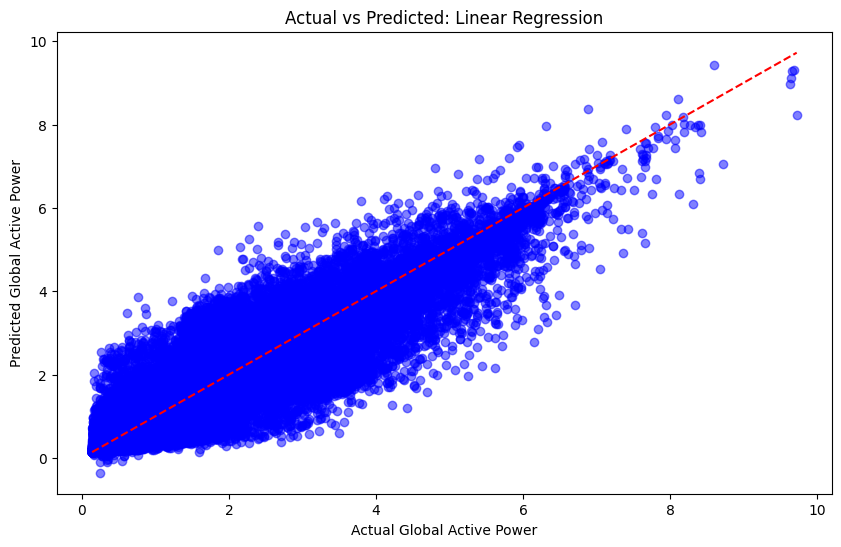

In [25]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_imputed, y_pred_lr, color='blue', alpha=0.5)
plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], color='red', linestyle='--')
plt.title('Actual vs Predicted: Linear Regression')
plt.xlabel('Actual Global Active Power')
plt.ylabel('Predicted Global Active Power')
plt.show()

**Random Forest Regressor**

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE (Mean Absolute Error)
mae_rf = mean_absolute_error(y_test_imputed, y_pred_rf)

# Calculate MSE (Mean Squared Error) and then take the square root to get RMSE
mse_rf = mean_squared_error(y_test_imputed, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Print the evaluation metrics
print(f'Mean Absolute Error (Random Forest): {mae_rf}')
print(f'Root Mean Squared Error (Random Forest): {rmse_rf}')


Mean Absolute Error (Random Forest): 0.07984676834221287
Root Mean Squared Error (Random Forest): 0.20528872123768976


**XG Boost Regressor**

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize and train the XGBoost model
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_imputed, y_train_imputed)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_imputed)

# Evaluate the XGBoost model
mae_xgb = mean_absolute_error(y_test_imputed, y_pred_xgb)

# Calculate MSE (Mean Squared Error) and then take the square root to get RMSE
mse_xgb = mean_squared_error(y_test_imputed, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)  # Taking the square root of MSE to get RMSE

# Print the evaluation metrics
print(f'Mean Absolute Error (XGBoost): {mae_xgb}')
print(f'Root Mean Squared Error (XGBoost): {rmse_xgb}')


Mean Absolute Error (XGBoost): 0.08122640839317154
Root Mean Squared Error (XGBoost): 0.20336264491516617


**Visualizing both the models **

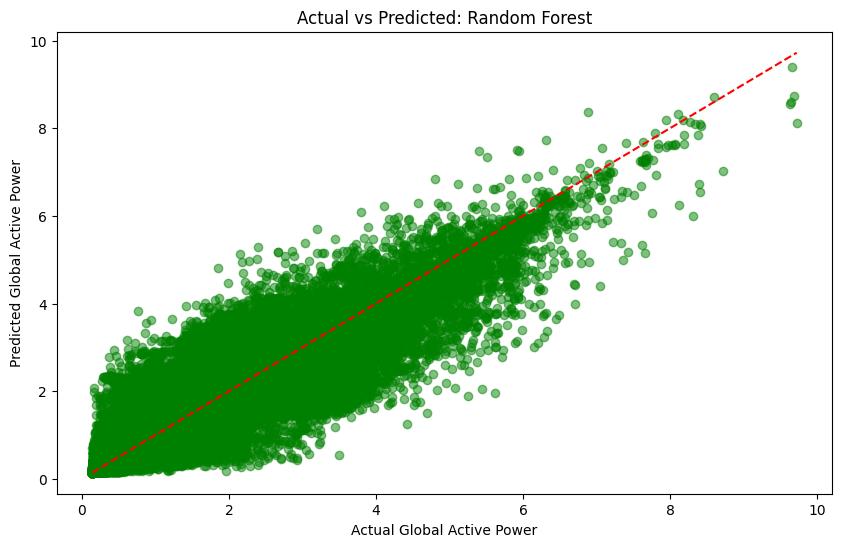

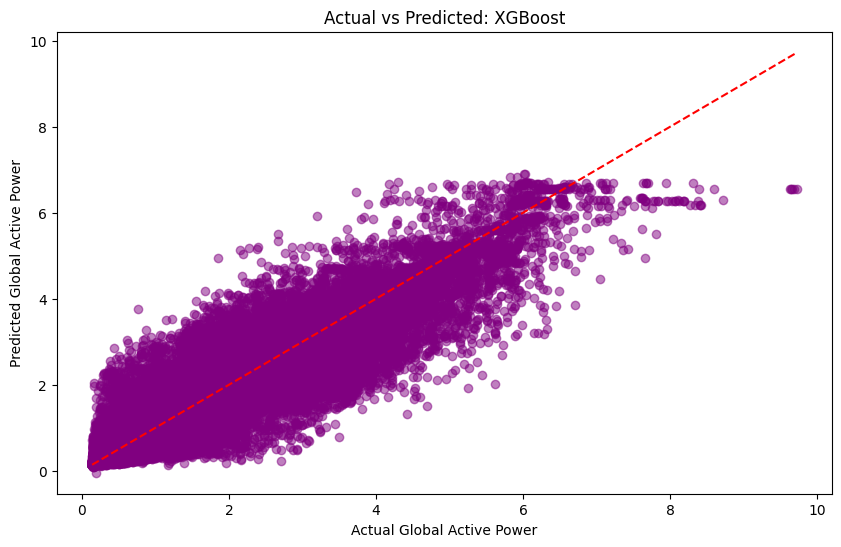

In [31]:
# Plot actual vs predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test_imputed, y_pred_rf, color='green', alpha=0.5)
plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], color='red', linestyle='--')
plt.title('Actual vs Predicted: Random Forest')
plt.xlabel('Actual Global Active Power')
plt.ylabel('Predicted Global Active Power')
plt.show()

# Plot actual vs predicted for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test_imputed, y_pred_xgb, color='purple', alpha=0.5)
plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], color='red', linestyle='--')
plt.title('Actual vs Predicted: XGBoost')
plt.xlabel('Actual Global Active Power')
plt.ylabel('Predicted Global Active Power')
plt.show()

**Comparison of models**

In [32]:
# Store the metrics in a dictionary
model_metrics = {
    'Linear Regression': {
        'MAE': mae_lr,
        'RMSE': rmse_lr
    },
    'Random Forest': {
        'MAE': mae_rf,
        'RMSE': rmse_rf
    },
    'XGBoost': {
        'MAE': mae_xgb,
        'RMSE': rmse_xgb
    }
}

# Display the metrics for all models
print(model_metrics)

{'Linear Regression': {'MAE': 0.08750227424218128, 'RMSE': np.float64(0.21431100958311033)}, 'Random Forest': {'MAE': 0.07984676834221287, 'RMSE': np.float64(0.20528872123768976)}, 'XGBoost': {'MAE': 0.08122640839317154, 'RMSE': np.float64(0.20336264491516617)}}


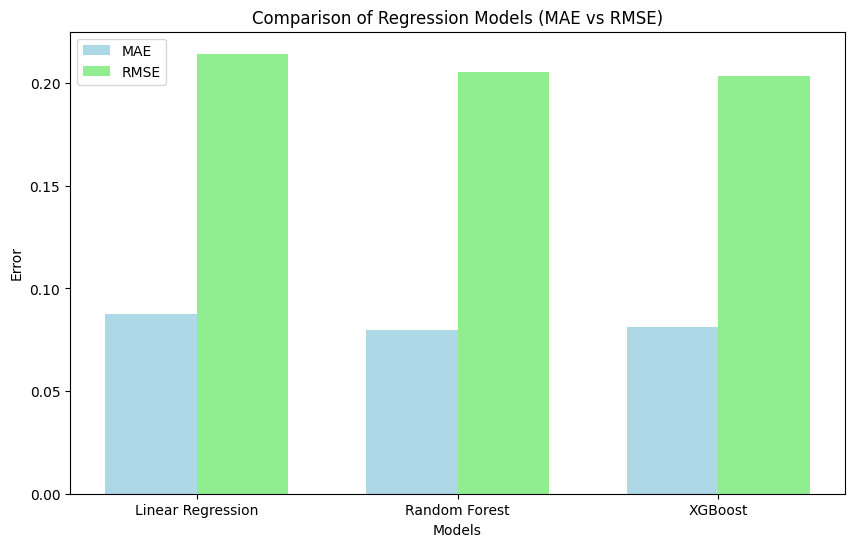

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the metrics
models = list(model_metrics.keys())
mae_values = [model_metrics[model]['MAE'] for model in models]
rmse_values = [model_metrics[model]['RMSE'] for model in models]

# Set up the bar chart
x = np.arange(len(models))  # Model labels
width = 0.35  # Bar width

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot MAE and RMSE as bars
rects1 = ax.bar(x - width/2, mae_values, width, label='MAE', color='lightblue')
rects2 = ax.bar(x + width/2, rmse_values, width, label='RMSE', color='lightgreen')

# Add text labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Error')
ax.set_title('Comparison of Regression Models (MAE vs RMSE)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.show()